In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import re
import string
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score ,confusion_matrix
from nltk.stem import WordNetLemmatizer, PorterStemmer


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Cybertrolling_Project/Data/train/train.csv")

In [ ]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
df['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [ ]:
df['comment_text'][1]

"D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)"

In [ ]:
df['comment_text'][2]

"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info."

In [ ]:
# check number of rows and columns 
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

Number of rows: 159571
Number of columns: 8


In [ ]:
# checking for any null values
df.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


Text(0, 0.5, 'Types of comments')

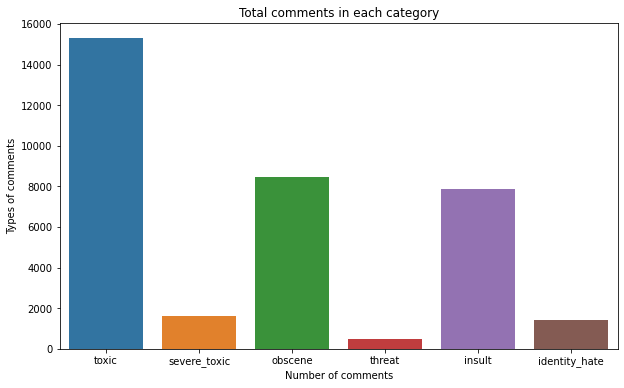

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(x = list(df.columns[2:]), y= list(df.iloc[:,2:].sum()))
plt.title('Total comments in each category')
plt.xlabel('Number of comments')
plt.ylabel('Types of comments')

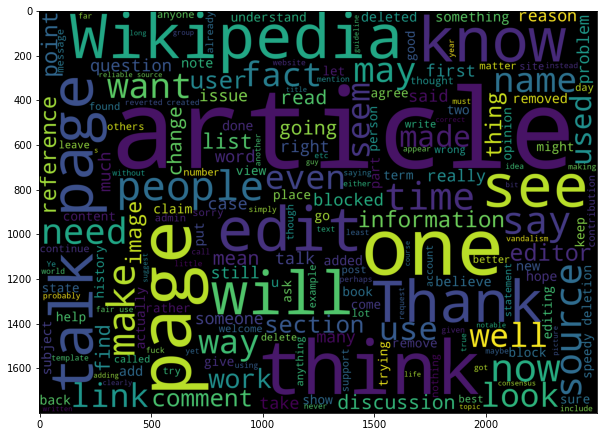

In [ ]:
from wordcloud import WordCloud, STOPWORDS

plt.figure(figsize=(10,8))
text = df.comment_text.values

cloud = WordCloud(stopwords=STOPWORDS, 
                  background_color='black', 
                  width=2500, 
                  height=1800).generate(''.join(text))
plt.imshow(cloud)

In [ ]:
comment_lengths = [len(comment.split()) for comment in df["comment_text"]]

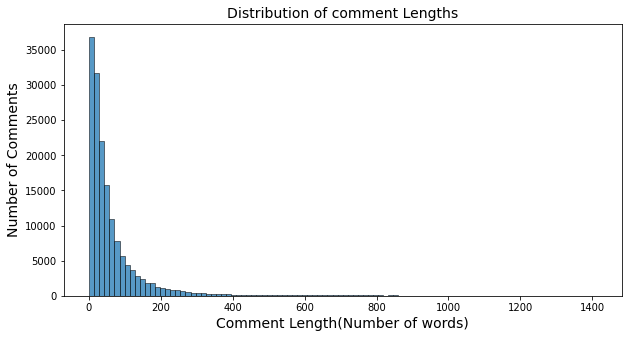

In [ ]:
# plot the distribution of tweet lengths
plt.figure(figsize=(10,5))
sns.histplot(comment_lengths, bins=100);
plt.xlabel("Comment Length(Number of words)", fontsize=14);
plt.ylabel("Number of Comments", fontsize=14);
plt.title("Distribution of comment Lengths", fontsize=14);

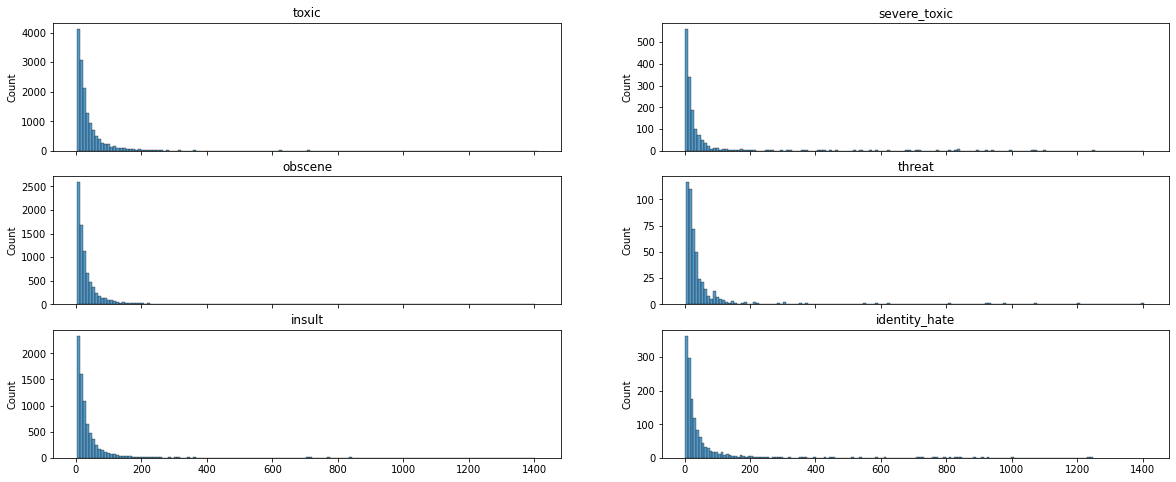

In [ ]:
labels = ['toxic','severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
fig, ax = plt.subplots(3, 2, figsize=(20,8), sharex=True)
axes =ax.ravel()
for i in range(6):
  comments = df.loc[df[labels[i]] == 1, :]
  comment_len = [len(comment.split()) for comment in comments["comment_text"]]
  sns.histplot(comment_len, ax=axes[i], bins = 150);
  axes[i].title.set_text(labels[i]);



In [ ]:
def  clean_text(text):
    text =  text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"\n", " ", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"weren't","were not",text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"'d", " would", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = text.translate(str.maketrans('', '', string.punctuation)) 
    return text

In [ ]:
df['clean_comments'] = df['comment_text'].apply(clean_text)

In [ ]:
# This function removes all emojis,emoticons,symbols.
def remove_emoji(string):
   emoji_pattern = re.compile("["
                       u"\U0001F600-\U0001F64F"  # emoticons
                       u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                       u"\U0001F680-\U0001F6FF"  # transport & map symbols
                       u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                       u"\U00002702-\U000027B0"
                       u"\U000024C2-\U0001F251"
                       "]+", flags=re.UNICODE)
   return emoji_pattern.sub(r'', string)

In [ ]:
# Removing Emojis and emoticons
df["clean_comments"] = df["clean_comments"].apply(remove_emoji)

In [ ]:
df[['comment_text','clean_comments']].head(3)

,comment_text,clean_comments
0,Explanation\nWhy the edits made under my usern...,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,daww he matches this background colour i am se...
2,"Hey man, I'm really not trying to edit war. It...",hey man i am really not trying to edit war it ...


In [ ]:
print(df['comment_text'][0])
print('-'*40)
print(df['clean_comments'][0])

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
----------------------------------------
explanation why the edits made under my username hardcore metallica fan were reverted they were not vandalisms just closure on some gas after i voted at new york dolls fac and please do not remove the template from the talk page since i am retired now892053827


In [ ]:
# After pre-processing
print(df['comment_text'][1])
print('-'*40)
print(df['clean_comments'][1])

D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)
----------------------------------------
daww he matches this background colour i am seemingly stuck with thanks  talk 2151 january 11 2016 utc


In [ ]:
# After pre-processing
print(df['comment_text'][2])
print('-'*40)
print(df['clean_comments'][2])

Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.
----------------------------------------
hey man i am really not trying to edit war it is just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info


In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
df['clean_comments'] = df['clean_comments'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')

def stemm(sentence):
    stem_word = ''
    for word in sentence.split():
        stem = stemmer.stem(word)
        stem_word += stem
        stem_word += ' '
    return stem_word

In [ ]:
df['clean_comments'] = df['clean_comments'].apply(stemm)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

vectrizer = TfidfVectorizer(analyzer='word',ngram_range=(1,3))
X = vectrizer.fit_transform(df['clean_comments'])

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    df.drop(['id','comment_text','clean_comments'],axis=1),
                                                    test_size=0.33, 
                                                    random_state=42)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import hamming_loss, accuracy_score

model = OneVsRestClassifier(estimator=LogisticRegression())
model.fit(X_train, y_train)

prediction = model.predict(X_test)
print('Accuracy Score: ', accuracy_score(y_test, prediction))
print('hamming loss : ', hamming_loss(y_test, prediction))

Accuracy Score:  0.9093982035359578
hamming loss :  0.024712458142641017


In [ ]:
cols_target = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
print(classification_report(y_test, prediction, target_names=cols_target))

               precision    recall  f1-score   support

        toxic       0.96      0.41      0.58      5083
 severe_toxic       0.65      0.13      0.22       526
      obscene       0.96      0.41      0.58      2831
       threat       0.00      0.00      0.00       152
       insult       0.87      0.32      0.47      2643
identity_hate       0.83      0.03      0.06       471

    micro avg       0.93      0.36      0.52     11706
    macro avg       0.71      0.22      0.32     11706
 weighted avg       0.91      0.36      0.51     11706
  samples avg       0.04      0.03      0.03     11706



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.multiclass import OneVsRestClassifier

model_NB = OneVsRestClassifier(estimator=MultinomialNB())
model_NB.fit(X_train, y_train)

prediction2 = model_NB.predict(X_test)
print('Accuracy Score: ', accuracy_score(y_test, prediction2))
print('hamming loss : ', hamming_loss(y_test, prediction2))

Accuracy Score:  0.8975293871892744
hamming loss :  0.03635655823316052


In [ ]:
print(classification_report(y_test, prediction2, target_names=cols_target))

               precision    recall  f1-score   support

        toxic       1.00      0.03      0.06      5083
 severe_toxic       0.00      0.00      0.00       526
      obscene       1.00      0.02      0.03      2831
       threat       0.00      0.00      0.00       152
       insult       1.00      0.00      0.01      2643
identity_hate       0.00      0.00      0.00       471

    micro avg       1.00      0.02      0.04     11706
    macro avg       0.50      0.01      0.02     11706
 weighted avg       0.90      0.02      0.04     11706
  samples avg       0.00      0.00      0.00     11706



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import hamming_loss, accuracy_score
from sklearn.linear_model import Perceptron
model_perceptron = OneVsRestClassifier(estimator=Perceptron())
model_perceptron.fit(X_train, y_train)

prediction3 = model_perceptron.predict(X_test)
print('Accuracy Score: ', accuracy_score(y_test, prediction3))
print('hamming loss : ', hamming_loss(y_test, prediction3))

Accuracy Score:  0.9122087392468524
hamming loss :  0.020018736904739296


In [ ]:
print(classification_report(y_test, prediction3, target_names=cols_target))

               precision    recall  f1-score   support

        toxic       0.83      0.67      0.74      5083
 severe_toxic       0.49      0.21      0.29       526
      obscene       0.88      0.68      0.76      2831
       threat       0.59      0.14      0.23       152
       insult       0.75      0.55      0.64      2643
identity_hate       0.57      0.26      0.36       471

    micro avg       0.81      0.60      0.69     11706
    macro avg       0.69      0.42      0.50     11706
 weighted avg       0.80      0.60      0.68     11706
  samples avg       0.06      0.05      0.05     11706



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import hamming_loss, accuracy_score
from sklearn.svm import SVC
model_SVC = OneVsRestClassifier(estimator=SVC())
model_SVC.fit(X_train, y_train)

prediction4 = model_SVC.predict(X_test)
print('Accuracy Score: ', accuracy_score(y_test, prediction4))
print('hamming loss : ', hamming_loss(y_test, prediction4))